In [36]:
%matplotlib widget

import numpy as np
from dataclasses import dataclass
import warnings

import matplotlib.pyplot as plt


In [ ]:
dt = 0.05
FF = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64)

Pnn0 = np.identity(4, dtype=np.float64)

qa = np.sqrt(10)
Qa = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64) * qa
QQ = FF @ Qa @ FF.T

HH = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float64)

vn = np.array([np.sqrt(10), np.sqrt(10)], dtype=np.float64)[:, np.newaxis]
Rn = vn @ vn.T

@dataclass
class xylist:
    sources: np.ndarray
    
    def __post_init__(self):
        
        self.sortedSources = self.sources[self.sources[:,2].argsort()[::-1]] # sort by flux
    
    def topNsources(self, numSources):
        return self.sortedSources[0:numSources, :]

In [ ]:
with open("xyIms.dat", 'rb') as ff:
    xyIms = np.load(ff, allow_pickle=True)

In [ ]:
# print(xyIms[0].sources[0:10, 0:2])
def source2colvec(sourceArray):

    nS = len(sourceArray.flat)
    stateVec = np.zeros((nS), dtype=np.float64)[:, np.newaxis]
    for idx, xx in enumerate(sourceArray.flat):
        stateVec[idx, 0] = xx
    
    return stateVec

def makeFFmatrix(sourceArray, velArray, dt):
    
    numSources = sourceArray.shape[0]
    numVels = velArray.shape[0]
    
    fShape = numSources * 2 + 2
    FF = np.identity(fShape, dtype=np.float64)
    
    # dtIdx = (0, fShape-1)
    for idx in range(numSources*2):
        FF[idx, -2 + (idx % 2)] = dt
        # FF[dtIdx[0], dtIdx[1]] = dt
        # dtIdx = [vv + 1 for vv in dtIdx]
        # print(FF[0, 2])
    
    return FF

def makeHHmatrix(numSources):
    
    HH = np.identity(numSources*2, dtype=np.float64)
    zc = np.zeros((numSources*2, 2), dtype=np.float64)
    
    return np.concatenate((HH, zc), axis=1)

def makeQmat(FF, qa):
    
    # Qa = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64) * qa
    Qa = np.identity(FF.shape[0], dtype=np.float64) * 10
    # print(Qa)
    Qa[FF.shape[0]-1, FF.shape[1]-1] = qa
    Qa[FF.shape[0]-2, FF.shape[1]-2] = qa
    
    # print(Qa, "\n")
    
    # np.set_printoptions(precision=3)
    # print(Qa)
    QQ = FF @ Qa @ FF.T
    return QQ

np.set_printoptions(precision=3, suppress=True)
print(makeQmat(FF, qa))
print(FF)


In [ ]:
for idx in range(4*2):
    print(idx % 2)

In [10]:
#====================================#
# init things
#====================================#

nsources = 4
sourceArray = xyIms[0].sources[0:nsources, 0:2]
sv = source2colvec(sourceArray)
vv = np.array([-10, 10], dtype=np.float64)[:, np.newaxis]

stateVec0 = np.concatenate((sv, vv), 0)
PPnn0 = np.identity(stateVec0.shape[0], dtype=np.float64)

## start loop over sources
xxTimeHist = []
ppTimeHist = []

Xnn = stateVec0
Pnn = PPnn0
FF = makeFFmatrix(sourceArray, Xnn[-2:], dt)
QQ = makeQmat(FF, qa)

HH = makeHHmatrix(nsources)
vn = np.array([np.sqrt(0.5)]*nsources*2, dtype=np.float64)[:, np.newaxis]
Rn = vn @ vn.T

xxTimeHist.append(Xnn)
ppTimeHist.append(Pnn)


for idx, xy in enumerate(xyIms[1:]):
    
    Xn1 = FF @ Xnn
    Pn1 = FF @ Pnn @ FF.T + QQ
    
    KK = Pn1 @ HH.T @ np.linalg.inv(HH @ Pn1 @ HH.T + Rn)
    
    zn = source2colvec(xy.sources[0:nsources, 0:2])
    Xn = Xn1 + KK @ (zn - HH @ Xn1)
    
    kh = KK @ HH
    ii = np.identity(kh.shape[0])
    Pn = (ii - kh) @ Pn1 @ (ii - kh).T + KK @ Rn @ KK.T
    
    Xnn = Xn
    Pnn = Pn
    
    xxTimeHist.append(Xnn)
    ppTimeHist.append(Pnn)
    
    # break
    
#     # sourceArray = xy.sources[0:nsources, 0:2]
#     sourceArray = xyIms[idx-1].sources[0:nsources, 0:2]
    
#     FF = makeFFmatrix(sourceArray, Xnn[-2:], dt)
#     QQ = makeQmat(FF, qa)
    
#     Pn1 = FF @ Pnn @ FF.T + QQ
#     Xn1 = FF @ Xnn
    
    
#     KK = Pn1 @ HH.T @ np.linalg.inv(HH @ Pn1 @ HH.T + Rn)
    
#     sourceArray = xy.sources[0:nsources, 0:2]
#     zn = source2colvec(sourceArray)
#     Xn = Xn1 + KK @ (zn - HH@Xn1)
    
#     Pn = (np.identity(Xn.shape[0]) - KK @ HH) @ Pn1 @ (np.identity(Xn.shape[0]) - KK @ HH) + KK @ Rn @ KK.T
    
#     break

# np.set_printoptions(precision=3, suppress=True)
# print(Xn)
# print(Pn)

                                                       

# print(stateVec)
# print(makeFFmatrix(sourceArray, vv, dt))
# print(makeHHmatrix(nsources))

#### adding target ID function 

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

vxhist = [xx[-2] for xx in xxTimeHist]
vyhist = [xx[-1] for xx in xxTimeHist]

plt.plot(vxhist, '.')
plt.plot(vyhist, '.')

In [37]:
[idx]*5


[3, 3, 3, 3, 3]

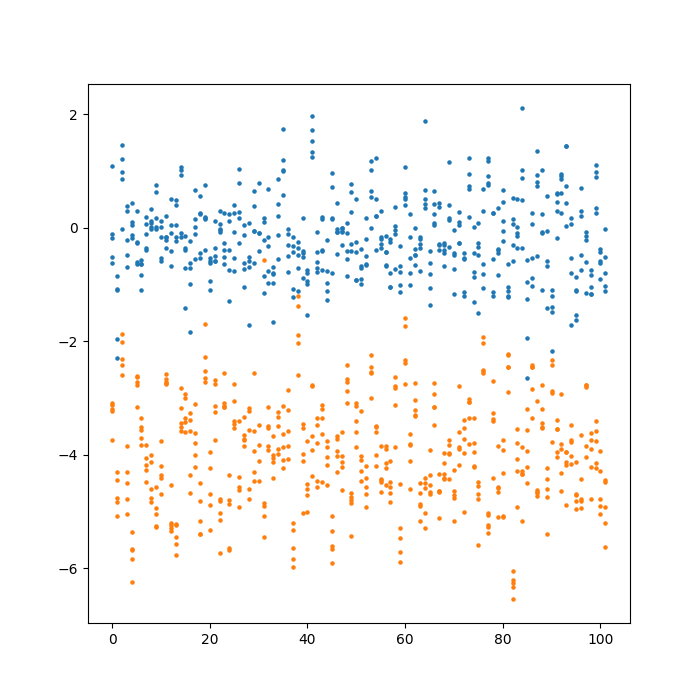

In [44]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

prevSourceCountConstant = 20
stateVectorSourceCount = 5

# initialize 0th source vector
prevSources = xyIms[0].sortedSources[0:prevSourceCountConstant, 0:3]


for idx, xy in enumerate(xyIms[1:]):

    # get current N number of sources
    currentSources = xy.sortedSources[0:stateVectorSourceCount, 0:3]

    # identify index of t=n sources from t=n-1 large list of sources
    idxID, idxUsed = idTargetFromPrevStep(currentSources, prevSources)
    
    orderedPrevSources = prevSources[idxID]
    usedCurrentSources = currentSources[idxUsed]

    # delta between source arrays
    dSources = usedCurrentSources - orderedPrevSources
    ax.scatter([idx]*len(idxID), dSources[:,0], s=5, c='C0' )
    ax.scatter([idx]*len(idxID), dSources[:,1], s=5, c='C1' )


    # print(idxID, end='')
    # print('\t', end='')
    # print(idxUsed)

    # re-init previous source vector with current index
    prevSources = xy.sortedSources[0:prevSourceCountConstant, 0:3]

    # break early for easier debugging
    if idx > 100:
        break

In [11]:
def idTargetFromPrevStep(cS, pS):
    '''
    cS: current sources column vector of xy centroid pairs. Needs to have N pairs
    pS: previous sources column vector of xy centroid pairs. Needs to have M pairs 
    
    M > N so that current sources can be found in a longer list of possible targets
    '''
    
    idxID = []
    idxUsed = []
    minNormConstant = 50
    
    for idcs, source in enumerate(cS):
        
        # find the distance between the current sources xyf coordinates and the previous M sources list
        dS = np.linalg.norm(pS[:,0:2] - source[0:2], axis=1)
        
        # pick the minimum distance as the most likely guess for which index the current source cooresponds to
        minIdx = np.argmin(dS)
        minNorm = np.min(dS)
        
        # only use target if norm of distance between them is smaller than a certain constant.
        # this is meant to exclude targets if they are not found in the list. For example
        # because the target has moved out of the field. 
        if minNorm < minNormConstant:
            idxID.append(minIdx)
            idxUsed.append(idcs)
    
    return idxID, idxUsed

nsources = 4
np.set_printoptions(edgeitems=30, linewidth=200, suppress=True, formatter=dict(float=lambda x: f"{x:+06.2f}"))


# Identify an initial set of top M brightest sources at time = 0
xy0 = xyIms[0].sortedSources[0:10,0:3]
prevSources = xy0

# get t=0 N brightest sources and make initial X_t=0 and P_t=0 vectors and matricies. 
nsv = xyIms[0].sortedSources[0:nsources, 0:2]
sv = source2colvec(nsv)
vv = np.array([-10, 10], dtype=np.float64)[:, np.newaxis]
X00 = np.concatenate((sv, vv), 0)
P00 = np.identity(stateVec0.shape[0], dtype=np.float64)

# make initial state transition matrix FF and process noise matrix QQ
# size and shape depends on the number of tracked targets
FF = makeFFmatrix(nsv, X00[-2:], dt)
QQ = makeQmat(FF, qa)

# make initial H and Rn matricies.
HH = makeHHmatrix(nsources)
vn = np.array([np.sqrt(0.5)]*nsources*2, dtype=np.float64)[:, np.newaxis]
Rn = vn @ vn.T

# make empty time hist arrays
xxTimeHist = []
ppTimeHist = []

xxTimeHist.append(X00)
ppTimeHist.append(P00)

# initialize "prev" set of variables

X1n = FF @ X00
P1n = FF @ P00 @ FF.T + QQ

prevNusedSources = nsources
prevP1n = P1n
prevX1n = X1n

# loop over each source list after time = 1
for idx, xy in enumerate(xyIms[1:]):
    
    # get the list of this steps brightest N sources
    currentSources = xy.sortedSources[0:nsources, 0:3]
    
    # identify index of t=n sources from t=n-1 large list of sources
    idxID, idxUsed = idTargetFromPrevStep(currentSources, prevSources)

    orderedPrevSources = prevSources[idxID]
    usedCurrentSources = currentSources[idxUsed]
    
    print(f"Loop: {idx:02d}\t", end='')
    for cs, ops in zip(usedCurrentSources, orderedPrevSources):
        # print(f"{cs[0]:06.1f},{cs[1]:06.1f} {ops[0]:06.1f},{ops[1]:06.1f} | ", end='')
        dxy = (cs - ops)[0:2]
        dxyn = np.linalg.norm(dxy)
        # print(f"{dxyn:+06.1f} | ", end='')
        print(f"{dxy[0]:+06.1f},{dxy[1]:+06.1f} | ", end='')
        # print((cs - ops)[0:2])
    print('')
    
    # check if number of sources has changed and recompute matrices accordingly
    if prevNusedSources != usedCurrentSources.shape[0]:
        
        currentNumSources = usedCurrentSources.shape[0]
        
        FF = makeFFmatrix(usedCurrentSources[:, 0:2], X00[-2:], dt)
        QQ = makeQmat(FF, qa)
        HH = makeHHmatrix(currentNumSources)
        vn = np.array([np.sqrt(0.5)]*currentNumSources*2, dtype=np.float64)[:, np.newaxis]
        Rn = vn @ vn.T
        
        # get indicies for masking state and uncertainty
        subInd = []
        for ii, ind in enumerate(idxUsed):
            subInd.append(ind + ii)
            subInd.append(ind + ii + 1)
        subInd.append(P1n.shape[0] - 2)
        subInd.append(P1n.shape[0] - 1)
        subInd = np.array(subInd)
        
        P1n = P1n[indMask]
        X1n = X1n[subInd]
        
        # raise ValueError
        
    # assign measurement vector
    Zn = source2colvec(usedCurrentSources[:, 0:2])
    KK = P1n @ HH.T @ np.linalg.inv(HH @ P1n @ HH.T + Rn)
    
    # estimate current state and uncertainty
    Xnn = X1n + KK @ (Zn - HH @ X1n)
    
    kh = KK @ HH
    ikh = np.identity(kh.shape[0]) - kh
    Pnn = ikh @ P1n @ ikh.T + KK @ Rn @ KK.T
    
    xxTimeHist.append(Xnn)
    ppTimeHist.append(Pnn)
    
    # do prediction step
    X1n = FF @ Xnn
    P1n = FF @ Pnn @ FF.T + QQ
    
    # do prev var stuff
    prevSources = xy.sortedSources[0:10,0:3]
    prevNusedSources = usedCurrentSources.shape[0]
    # print(prevNusedSources)
    
    # print("loop")
    
    # break
    if idx >= 4:
        break
        
    # print(f"{xy.sortedSources[0, 0]:3.1f}, {xy.sortedSources[0, 1]:3.1f}\t" + 
    #       f"{xy.sortedSources[1, 0]:3.1f}, {xy.sortedSources[1, 1]:3.1f}\t" + 
    #       f"{xy.sortedSources[2, 0]:3.1f}, {xy.sortedSources[2, 1]:3.1f}\t" + 
    #       f"{xy.sortedSources[3, 0]:3.1f}, {xy.sortedSources[3, 1]:3.1f}")
[print(xx.T) for xx in xxTimeHist];

Loop: 00	-000.2,-003.1 | -000.6,-003.2 | -000.1,-003.7 | -000.5,-003.1 | 
Loop: 01	-002.0,-005.1 | -001.1,-004.8 | -001.1,-004.8 | -000.9,-004.3 | 
Loop: 02	+001.5,-001.9 | +000.9,-002.4 | +001.0,-002.0 | +001.2,-002.6 | 
Loop: 03	-000.7,-004.5 | -000.2,-003.8 | +000.4,-005.0 | +000.3,-004.3 | 
Loop: 04	+000.4,-005.8 | -000.1,-006.2 | +000.1,-005.4 | +000.1,-005.7 | 
[[+130.73 +803.11 +294.01 +375.85 +178.16 +195.04 +878.95 +623.99 -10.00 +10.00]]
[[+131.03 +800.47 +293.86 +373.11 +178.53 +191.79 +878.92 +621.39 -09.95 +09.75]]
[[+129.40 +795.71 +293.10 +368.68 +878.15 +616.88 +178.01 +187.81 -09.97 +09.08]]
[[+113.86 +776.84 +276.97 +349.26 +862.14 +597.87 +422.12 +475.64 -00.72 +19.90]]
[[+158.97 +818.14 +322.56 +391.21 +207.18 +209.27 +468.21 +517.13 -33.31 +03.93]]
[[+137.11 +789.99 +300.13 +362.67 +184.93 +181.60 +446.00 +489.17 -39.50 -04.77]]


In [ ]:
# print(P1n)
# print(X1n, end='\n\n')
# print(idxUsed)
# print(P1n.shape)

subInd = []
for ii, ind in enumerate(idxUsed):
    subInd.append(ind + ii)
    subInd.append(ind + ii + 1)
subInd.append(P1n.shape[0] - 2)
subInd.append(P1n.shape[0] - 1)
subInd = np.array(subInd)

# print(subInd)
indMask = np.ix_(subInd, subInd)
print(P1n[indMask], end='\n\n')
print(X1n[subInd])

    
# indMask = np.array((0,1,2,3))
# II = np.ix_(indMask, indMask)
# # print(II)
# # print(indMask)
# print(P1n[II])